Model: "ff"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lenet_model_6 (LenetModel)      │ (None, 1)              │     6,431,969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,431,969 (24.54 MB)

 Trainable params: 6,431,541 (24.53 MB)

 Non-trainable params: 428 (1.67 KB)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7004 - loss: 0.5982 - val_accuracy: 0.5981 - val_loss: 0.7126
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8654 - loss: 0.3229 - val_accuracy: 0.7647 - val_loss: 0.4725
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8875 - loss: 0.2682 - val_accuracy: 0.8610 - val_loss: 0.3497
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9293 - loss: 0.1879 - val_accuracy: 0.9040 - val_loss: 0.3049
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9370 - loss: 0.1651 - val_accuracy: 0.8675 - val_loss: 0.5024
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9437 - loss: 0.1527 - val_accuracy: 0.9281 - val_loss: 0.2342
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9490 - loss: 0.1334 - val_accuracy: 0.9321 - val_loss: 0.2059
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9592 - loss: 0.1120 - val_ac

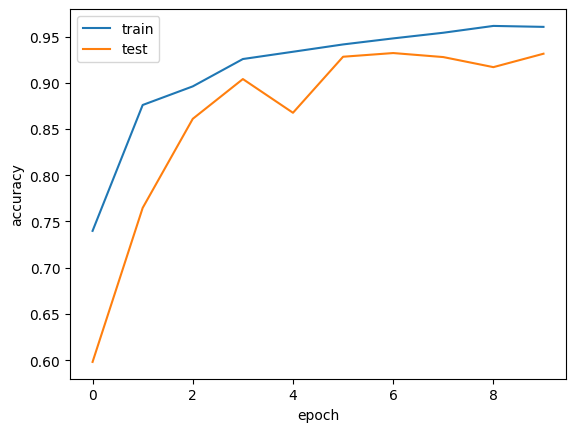

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np

dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split='train')

def reshape_resize(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.float32) 
    return image, label

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
LEN = len(dataset)

train_size = int(LEN * TRAIN_RATIO)
val_size = int(LEN * VAL_RATIO)

train_ds = dataset.take(train_size)
remaining_ds = dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


train_ds = train_ds.map(reshape_resize).batch(32)
val_ds = val_ds.map(reshape_resize).batch(32)
test_ds = test_ds.map(reshape_resize).batch(32)

class FeatureExtractor(Layer):
    def __init__(self, filters_1, filters_2, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters=filters_1, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=strides*2)
        self.conv_2 = Conv2D(filters=filters_2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=strides*2)

    def call(self, x, training=None):
        x = self.conv_1(x)
        x = self.batch_1(x, training=training)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.batch_2(x, training=training)
        x = self.pool_2(x)
        return x

class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        self.feature_extractor = FeatureExtractor(6, 16, (1, 1), 1, "valid", "relu", (1, 1))
        self.flatten = Flatten()
        self.dense_1 = Dense(128, activation="relu")
        self.batch_1 = BatchNormalization()
        self.dense_2 = Dense(64, activation="relu")
        self.batch_2 = BatchNormalization()
        self.output_layer = Dense(1, activation="sigmoid")

    def call(self, x, training=None):
        x = self.feature_extractor(x, training=training)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x, training=training)
        x = self.dense_2(x)
        x = self.batch_2(x, training=training)
        x = self.output_layer(x)
        return x
        
# Create the model
func_input = Input(shape=(224, 224, 3), name="input")
feature_sub_classed = LenetModel()
func_output = feature_sub_classed(func_input)
model = Model(inputs=func_input, outputs=func_output, name="ff")

# Print model summary
model.summary()

# Compile and train the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history=model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','test'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()




173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9369 - loss: 0.2662


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


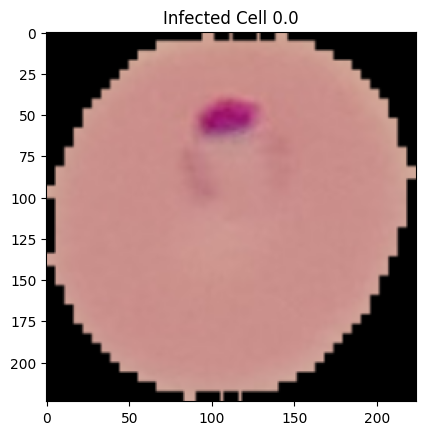

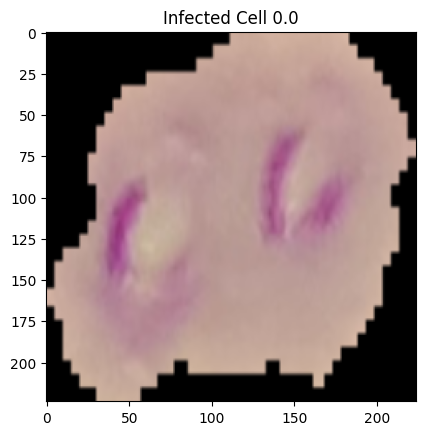

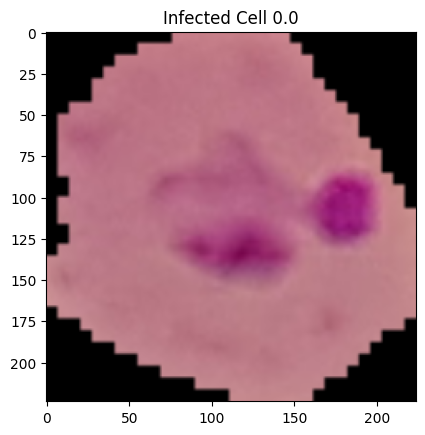

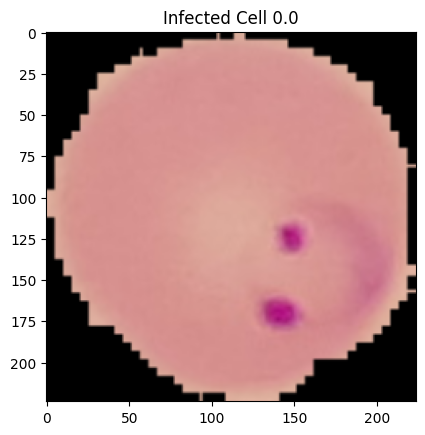

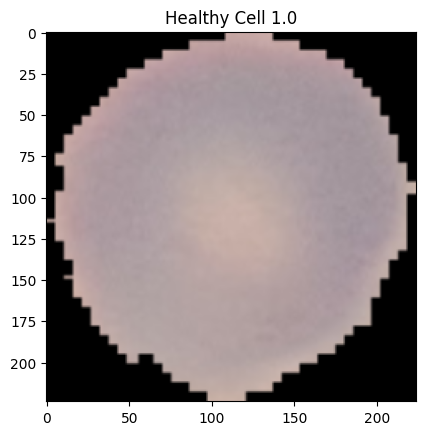

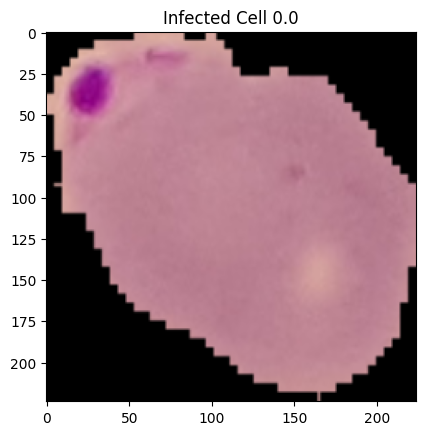

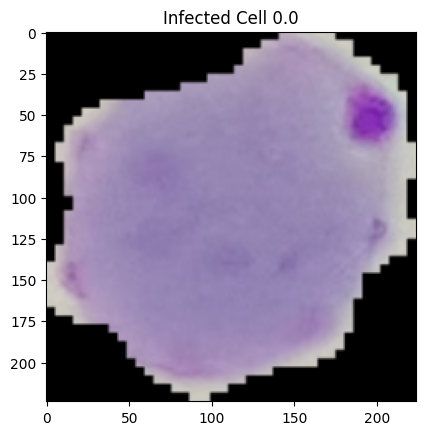

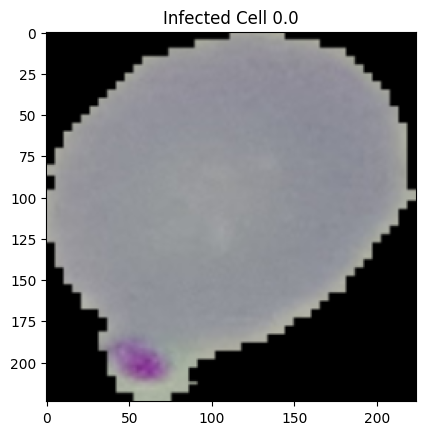

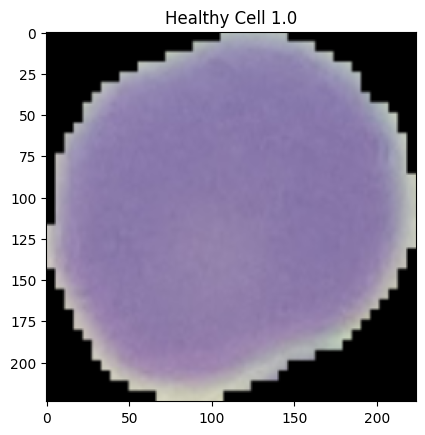

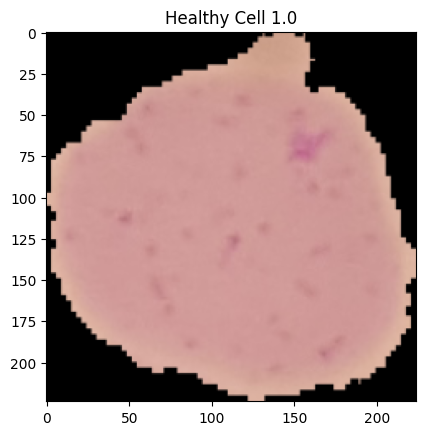

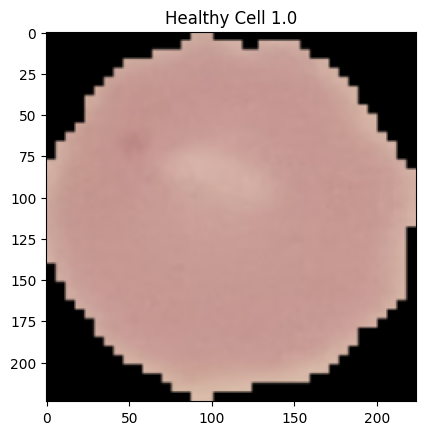

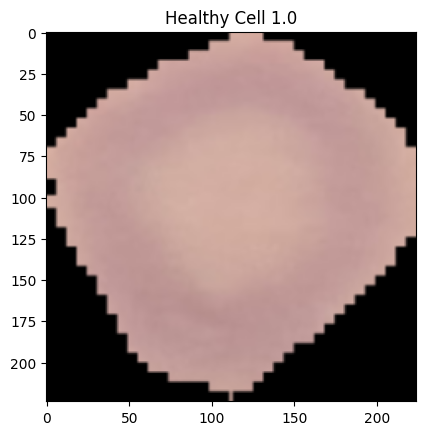

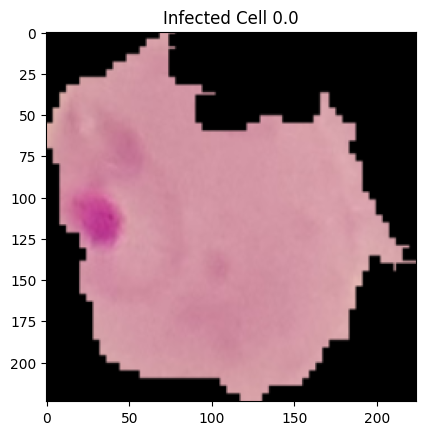

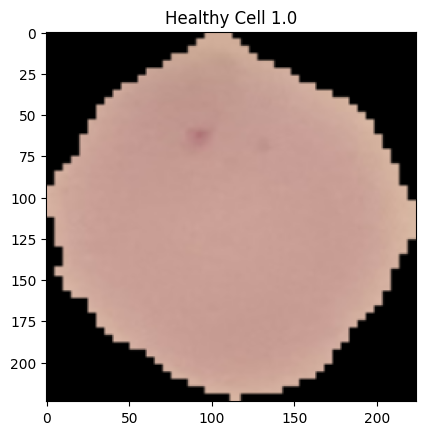

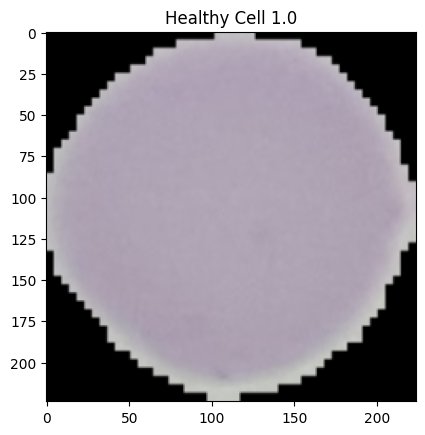

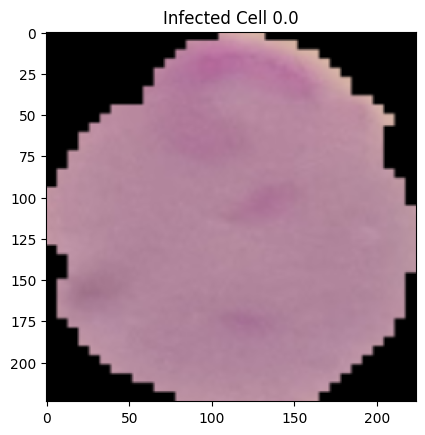

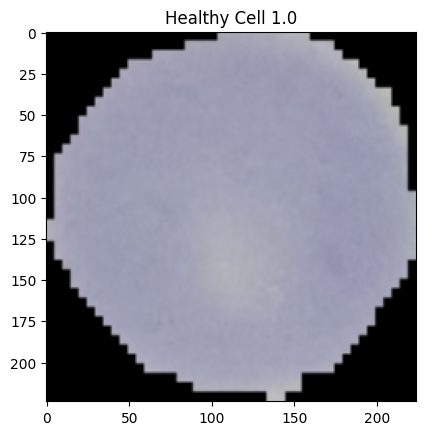

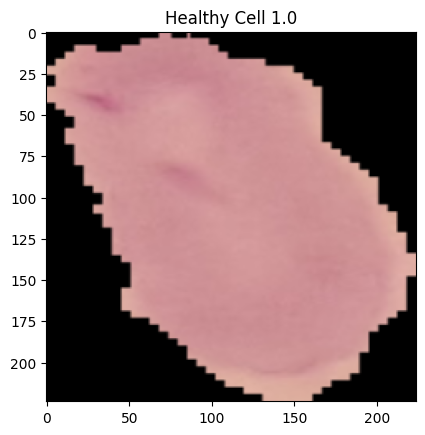

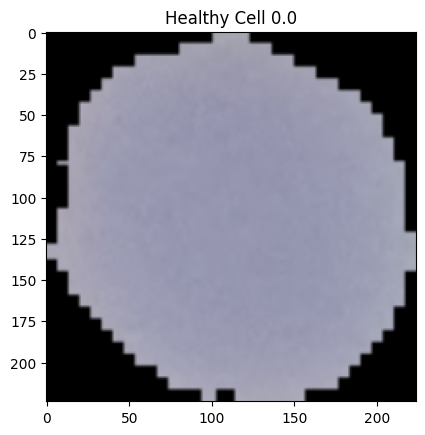

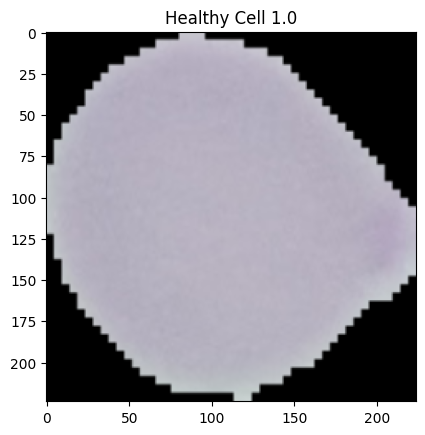

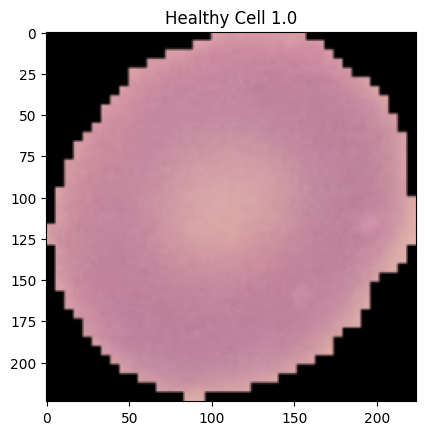

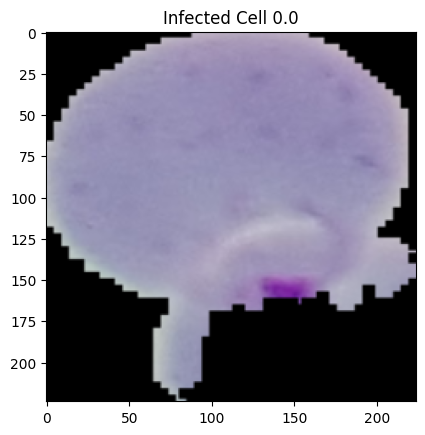

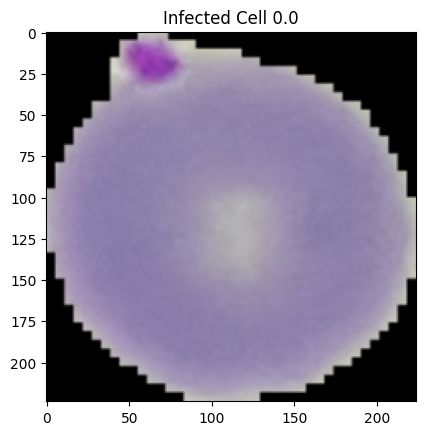

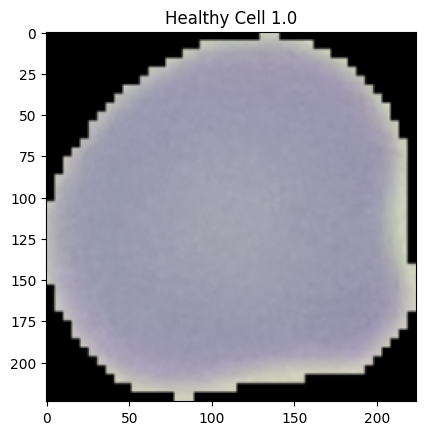

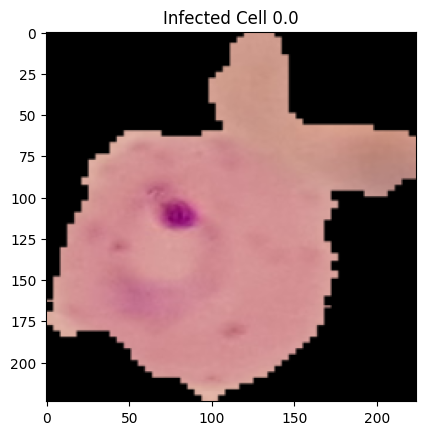

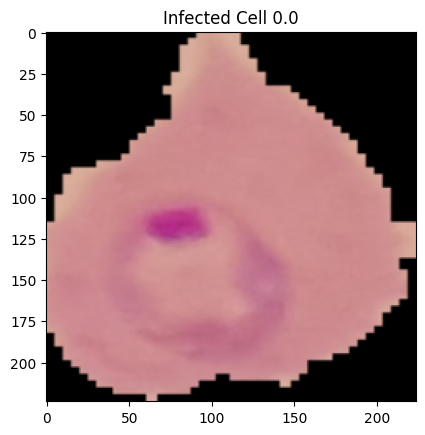

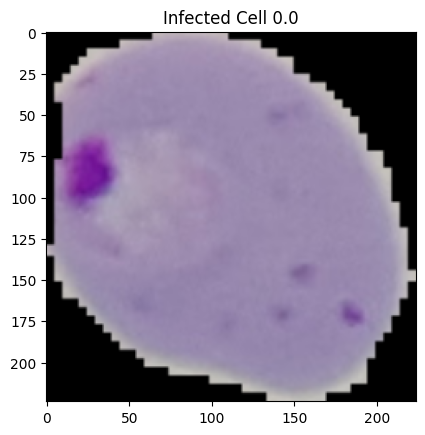

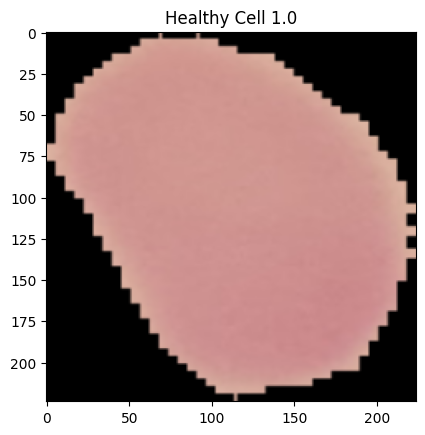

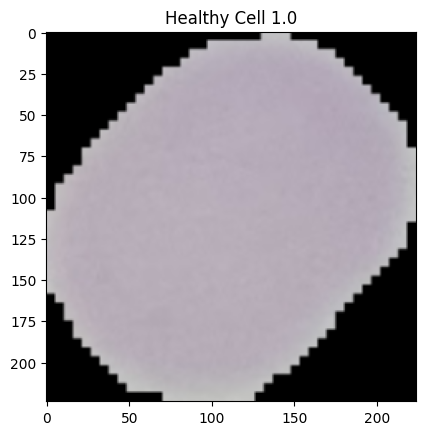

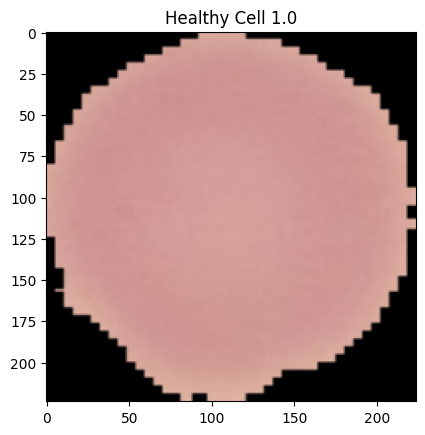

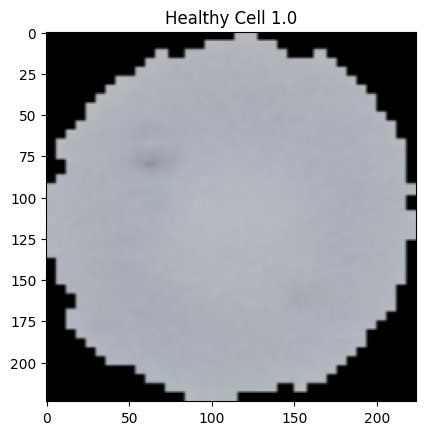

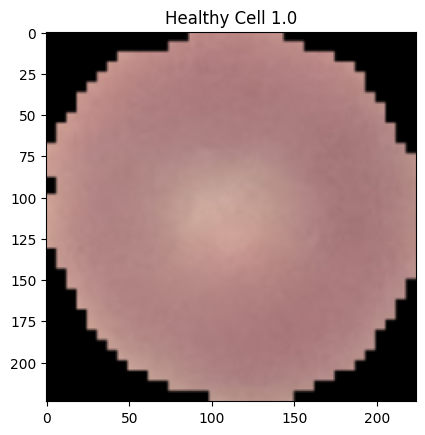

In [15]:
model.evaluate(test_ds)

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(len(images)):
        plt.figure()
        plt.imshow(images[i])
        #plt.axis('off')
        if predictions[i][0] > 0.5:
            plt.title(f"Healthy Cell {labels[i]}")
        else:
            plt.title(f"Infected Cell {labels[i]}")
        plt.show()